In [1]:
import pybaseball as pb
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from sklearn import metrics, preprocessing
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [2]:
pb.cache.enable()
thisYearPitches = pb.statcast(start_dt = '2023-03-29', end_dt = '2023-10-02')
lastYearPitches = pb.statcast(start_dt = '2022-04-06', end_dt = '2022-10-05')
#Using pybaseball, I downloaded all pitches thrown this season.

This is a large query, it may take a moment to complete


100%|██████████| 188/188 [01:10<00:00,  2.66it/s]


This is a large query, it may take a moment to complete


100%|██████████| 183/183 [01:18<00:00,  2.32it/s]


# Cleaning Data

### To clean the data, I edited the pitch data to only include at bats that ended in balls put in play. Along with this, I removed any features unrelated to player identification, pitch identification, and batted ball information. I also made small edits to some features to enhance precision and readability. I did this with two years of data that way I could easily train the model on last year's data and have it predict on this year's data.

In [3]:
thisYearBBE = thisYearPitches.loc[thisYearPitches['description'] == 'hit_into_play']
thisYearBBE = thisYearBBE.loc[thisYearBBE['events'] != 'catcher_interf']
thisYearBBE = thisYearBBE.drop(['release_speed', 'release_pos_x', 'release_pos_z', 'spin_dir', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 'spin_axis', 'delta_home_win_exp', 'delta_run_exp', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'des', 'woba_denom', 'babip_value', 'iso_value', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_woba_using_speedangle', 'woba_value', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'hit_distance_sc', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'vx0', 'inning_topbot', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team'], axis=1)
#I kept all occurences of the ball being hit into play, not including catcher's interference because it doesn't produce batted ball data.

In [4]:
lastYearBBE = lastYearPitches.loc[lastYearPitches['description'] == 'hit_into_play']
lastYearBBE = lastYearBBE.loc[lastYearBBE['events'] != 'catcher_interf']
lastYearBBE = lastYearBBE.drop(['release_speed', 'release_pos_x', 'release_pos_z', 'spin_dir', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 'spin_axis', 'delta_home_win_exp', 'delta_run_exp', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'des', 'woba_denom', 'babip_value', 'iso_value', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_woba_using_speedangle', 'woba_value', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'hit_distance_sc', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'vx0', 'inning_topbot', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team'], axis=1)

In [5]:
BBE = pd.DataFrame(thisYearBBE)
BBE2 = pd.DataFrame(lastYearBBE)

In [6]:
BBE = BBE.dropna(how = 'any')
BBE2 = BBE2.dropna(how = 'any')

In [7]:
BBE['events'] = BBE['events'].replace(['single', 'double', 'triple', 'home_run'], 1)
BBE['events'] = BBE['events'].replace(['field_out', 'field_error', 'grounded_into_double_play', 'force_out', 'sac_fly', 'sac_bunt', 'double_play', 'fielders_choice', 'fielders_choice_out', 'sac_fly_double_play', 'triple_play', 'sac_bunt_double_play'], 0)
BBE2['events'] = BBE2['events'].replace(['single', 'double', 'triple', 'home_run'], 1)
BBE2['events'] = BBE2['events'].replace(['field_out', 'field_error', 'grounded_into_double_play', 'force_out', 'sac_fly', 'sac_bunt', 'double_play', 'fielders_choice', 'fielders_choice_out', 'sac_fly_double_play', 'triple_play', 'sac_bunt_double_play'], 0)
#This changes all hits into a 1 and all outs in 0 so that machine learning models can properly train themselves.

In [8]:
BBE = BBE[['pitch_type', 'game_date', 'player_name', 'batter', 'pitcher', 'description', 'pitch_name', 'launch_speed', 'launch_angle', 'events', 'zone', 'launch_speed_angle', 'estimated_ba_using_speedangle']]
BBE2 = BBE2[['pitch_type', 'game_date', 'player_name', 'batter', 'pitcher', 'description', 'pitch_name', 'launch_speed', 'launch_angle', 'events', 'zone', 'launch_speed_angle', 'estimated_ba_using_speedangle']]

In [9]:
#Perform one-hot encoding
one_hot_encoded = pd.get_dummies(BBE['launch_speed_angle'], prefix='')
one_hot_encoded2 = pd.get_dummies(BBE2['launch_speed_angle'], prefix='')

#Concatenate the original DataFrame with the one-hot encoded columns
BBE = pd.concat([BBE, one_hot_encoded], axis=1)
BBE2 = pd.concat([BBE2, one_hot_encoded2], axis=1)

In [10]:
BBE.columns = ['pitch_type', 'game_date', 'pitcher_name', 'batter', 'pitcher', 'description', 'pitch_name', 'launch_speed', 'launch_angle', 'events', 'zone', 'launch_speed_angle', 'estimated_ba_using_speedangle', 'weak_contact', 'topped', 'under', 'flare', 'solid_contact', 'barreled']
BBE2.columns = ['pitch_type', 'game_date', 'pitcher_name', 'batter', 'pitcher', 'description', 'pitch_name', 'launch_speed', 'launch_angle', 'events', 'zone', 'launch_speed_angle', 'estimated_ba_using_speedangle', 'weak_contact', 'topped', 'under', 'flare', 'solid_contact', 'barreled']

In [11]:
BBE['launch_speed_angle'] = BBE['launch_speed_angle'].replace([1], 7)
BBE['launch_speed_angle'] = BBE['launch_speed_angle'].replace([3], 1)
BBE['launch_speed_angle'] = BBE['launch_speed_angle'].replace([7], 3)
BBE['launch_speed_angle'] = BBE['launch_speed_angle'].replace([4], 7)
BBE['launch_speed_angle'] = BBE['launch_speed_angle'].replace([5], 4)
BBE['launch_speed_angle'] = BBE['launch_speed_angle'].replace([7], 5)
#This reorders the column so that the outcomes that the numbers are sorted by their likeliness to produce a hit.

In [12]:
BBE2['launch_speed_angle'] = BBE2['launch_speed_angle'].replace([1], 7)
BBE2['launch_speed_angle'] = BBE2['launch_speed_angle'].replace([3], 1)
BBE2['launch_speed_angle'] = BBE2['launch_speed_angle'].replace([7], 3)
BBE2['launch_speed_angle'] = BBE2['launch_speed_angle'].replace([4], 7)
BBE2['launch_speed_angle'] = BBE2['launch_speed_angle'].replace([5], 4)
BBE2['launch_speed_angle'] = BBE2['launch_speed_angle'].replace([7], 5)

# Testing Data

### To test the data, I used different combinations of features across different machine learning algorithms to see which combination of the two produced the most accurate results. A combination of KNN and XGBoost achieved the highest accuracy, just over 80%. Logistic regression, extra forest, and random forest models achieved between 76% and 79%. I tested each model with data that possessed KNN predictions and data that did not. I also tested an unsupervised learning model, KMeans, but it performed very poorly with only a 55% accuracy.

In [13]:
#Here I tested out different combinations of features to see which brought the best results.
X = BBE[['launch_speed', 'launch_angle', 'launch_speed_angle', 'zone', 'weak_contact', 'topped', 'under', 'flare', 'solid_contact', 'barreled']]
#X = BBE[['launch_speed', 'launch_angle', 'launch_speed_angle', 'zone']]
#X = BBE[['launch_speed', 'launch_angle', 'zone']]
#X = BBE[['launch_speed', 'launch_angle', 'launch_speed_angle', 'weak_contact', 'topped', 'under', 'flare', 'solid_contact', 'barreled']]
y = BBE['events']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=24)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_train, y_train, test_size = .5, random_state=24)
#Double split so that the KNN model can fit a separate train data set than the training data the XGBoost will see.
#If there was only one training dataset, the KNN model would have already seen it when it predicts on it 2 cells down.

In [15]:
#This model will look at data points will very similar features and make predictions based off of this.
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [100, 150, 190, 250, 300],
    'p': [1, 2],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 20, 30]
}

#Find the best parameters from the grid above
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
grid_search.fit(X2_train, y2_train)

#Output the best parameters
print("Best Parameters:", grid_search.best_params_)

#Get the best KNN model from the grid search
best_knn_model = grid_search.best_estimator_

Best Parameters: {'leaf_size': 10, 'n_neighbors': 190, 'p': 2, 'weights': 'uniform'}


In [16]:
#Add a feature that consists of the knn model predictions to give more variables for the XGBoost to look at.
knn_train_predictions = best_knn_model.predict(X_train)
knn_test_predictions = best_knn_model.predict(X_test)
X_train_concatenated = np.column_stack((X_train, knn_train_predictions))
X_test_concatenated = np.column_stack((X_test, knn_test_predictions))

In [17]:
#XGBoost is a tree algorithm that builds itself off of previously made trees to help increase accuracy.
#It was the best performing model that was tested.
xgbmo = xgb.XGBClassifier(objective='binary:logistic', random_state=24)

param_grid = {
    'n_estimators': [100, 200, 240, 300, 400],
    'learning_rate': [0.1],
    'max_depth': [3],
    'min_child_weight': [7],
    'gamma': [0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

#Cross validation to better test accuracy of model
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)

#Find the best parameters from the grid above
grid_search = GridSearchCV(estimator=xgbmo, param_grid=param_grid, cv=cv, verbose=2, n_jobs=-1)

grid_search.fit(X_train_concatenated, y_train)

#Output the best parameters
print("Best Parameters:", grid_search.best_params_)

#Get the best XGBoost model from the grid search 
best_model = grid_search.best_estimator_

cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

#Print the mean and standard deviation of the cross-validated scores
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

y_pred = best_model.predict(X_test_concatenated)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 240, 'subsample': 0.6}
Mean Accuracy: 0.8049466910952653
Standard Deviation: 0.001718697023082345


Accuracy on Test Set: 0.8051423027166882


Text(0.5, 257.44, 'Predicted label')

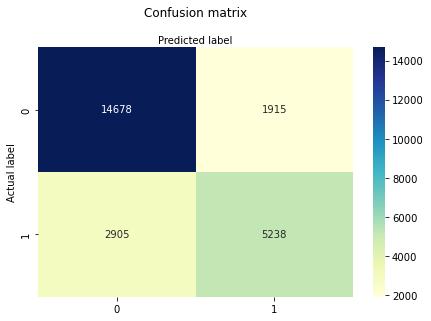

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#This prints the confusion matrix made above to see where correct and incorrect predictions occur.

In [19]:
#This shows the accuracy of each outcome. The algorithm predicts that an out will be a hit far more than any other error,
#this is where most improvements will likely be made.
target_names = ['out', 'hit']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         out       0.83      0.88      0.86     16593
         hit       0.73      0.64      0.68      8143

    accuracy                           0.81     24736
   macro avg       0.78      0.76      0.77     24736
weighted avg       0.80      0.81      0.80     24736



In [20]:
#Testing logistic regression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(round(accuracy_score(y_test, y_pred) * 100, 5), "%")

78.34331 %


In [21]:
#Testing logistic regression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
pipeline.fit(X_train_concatenated, y_train)
y_pred = pipeline.predict(X_test_concatenated)
print(round(accuracy_score(y_test, y_pred) * 100, 5), "%")

79.33376 %


In [22]:
#Testing the extra trees model.
etf = ExtraTreesClassifier(n_estimators = 100)
etf.fit(X_train, y_train)
etf_pred = etf.predict(X_test)
print(round(accuracy_score(y_test, etf_pred)*100,5), "%")

75.9662 %


In [23]:
#Testing the extra trees model.
etf = ExtraTreesClassifier(n_estimators = 100)
etf.fit(X_train_concatenated, y_train)
etf_pred = etf.predict(X_test_concatenated)
print(round(accuracy_score(y_test, etf_pred)*100,5), "%")

76.04706 %


In [24]:
#Testing the random forest model.
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
print(round(accuracy_score(y_test, rf_prediction)*100,5), "%")

76.90815 %


In [25]:
#Testing the random forest model.
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_concatenated, y_train)
rf_prediction = rf.predict(X_test_concatenated)
print(round(accuracy_score(y_test, rf_prediction)*100,5), "%")

76.92836 %


In [26]:
#Testing an unsupervised learning algorithm
kmeans_model = KMeans(n_clusters=2, random_state=24)
kmeans_model.fit(X_train_concatenated)
y_kmeans_pred = kmeans_model.predict(X_test_concatenated)
print(round(accuracy_score(y_test, y_kmeans_pred)*100,5), "%")

45.5207 %


# Making Predictions

### A prediction is made on each batted ball hit by a batter to find their expected batting average(xBA). The model is trained on all data except the data that the player provided. Using these predictions, we will also find an expected batting average against(xBAA) value for every pitcher. Finally, the xBA and xBAA value produced is added to a CSV to be displayed on the shiny application.

In [35]:
pdf = pd.read_csv(r'C:\Users\aveng\Downloads\Batters1.csv')
pdf2 = pd.read_csv(r'C:\Users\aveng\Downloads\Pitchers1.csv')

In [28]:
X_train = BBE2[['launch_speed', 'launch_angle', 'launch_speed_angle', 'zone', 'weak_contact', 'topped', 'under', 'flare', 'solid_contact', 'barreled']]
y_train = BBE2['events']
X_test = BBE[['launch_speed', 'launch_angle', 'launch_speed_angle', 'zone', 'weak_contact', 'topped', 'under', 'flare', 'solid_contact', 'barreled']]
y_test = BBE['events']
df = BBE

In [29]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_train, y_train, test_size = .5, random_state=24)
#Two training sets for the same reasons as listed above.

In [31]:
#Train the model on last year's data

#KNN classifier with specified parameters
knn = KNeighborsClassifier(n_neighbors=190, p=2, weights='uniform', leaf_size=10)
knn.fit(X2_train, y2_train)
knn_train_predictions = knn.predict(X_train)
knn_test_predictions = knn.predict(X_test)
newTrain = np.column_stack((X_train, knn_train_predictions))
newTest = np.column_stack((X_test, knn_test_predictions))
#XGBoost classifier with specified parameters
xgbmo = xgb.XGBClassifier(objective='binary:logistic', random_state=24, n_estimators=240, learning_rate=0.1, max_depth=3,  min_child_weight=7, gamma=0.3, subsample=0.6, colsample_bytree=0.8)
xgbmo.fit(newTrain, y_train)
y_pred = xgbmo.predict(newTest)
df['predicted_values'] = y_pred

In [47]:
unique_batters = df['batter'].unique()

progress_bar_batters = tqdm(total=len(unique_batters), desc="Processing batters", unit="batter")

#Loop over every batter
for x in unique_batters:
    row = pdf.loc[pdf['batter'] == x]
    playerabs = row['abs'].values[0]
    predictions = df.loc[df['batter'] == x, 'predicted_values'].sum()
    xBA = round(predictions / playerabs, 4)
    pdf.loc[pdf['batter'] == x, 'xBA'] = xBA
    #The stat is calculated and imported into the xBA column at the row the player is.
    progress_bar_batters.update(1)
    
progress_bar_batters.close()

Processing batters: 100%|██████████| 651/651 [00:01<00:00, 615.99batter/s]


In [49]:
unique_pitchers = df['pitcher'].unique()

progress_bar_pitchers = tqdm(total=len(unique_pitchers), desc="Processing pitchers", unit="pitcher")

#Loop over every pitcher
for x in unique_pitchers:
    row = pdf2.loc[pdf2['pitcher'] == x]
    pitcherabs = row['pabs'].values[0]
    predictions = df.loc[df['pitcher'] == x, 'predicted_values'].sum()
    xBAA = round(predictions / pitcherabs, 4)
    pdf2.loc[pdf2['pitcher'] == x, 'xBAA'] = xBAA
    #The stat is calculated and imported into the xBAA column at the row the player is.
    progress_bar_pitchers.update(1)
    
progress_bar_pitchers.close()

Processing pitchers: 100%|██████████| 862/862 [00:01<00:00, 603.74pitcher/s]


In [52]:
pdf.to_csv(r'C:\Users\aveng\Downloads\Batters.csv', index=False)

In [53]:
pdf2.to_csv(r'C:\Users\aveng\Downloads\Pitchers.csv', index=False)

In [55]:
df.to_csv(r'C:\Users\aveng\Downloads\Predictions.csv', index=False)